In [1]:
## Started overall formatting here. We may want to separate functions into different files so it is easier to work on

### Imports
import numpy as np
import matplotlib.pyplot as plt
from numba import njit  
import sys
from numpy.polynomial.legendre import leggauss
from scipy.sparse import diags
from scipy.sparse.linalg import bicgstab
from numpy.linalg import norm
from matplotlib import cm
from matplotlib.colors import Normalize


In [68]:

### Arguments
N = 128 # Number of divisions in the radial direction
G = 9.81  # Acceleration due to gravity (m/s^2)
NU = 1    # Kinematic viscosity (m^2/s)
DT = 0.00005  # Time step (s)
SIMULATION_TIME = 10  # Total time for simulation (s)


# Explicit Solution

# Explicit Solution, Matrix Form

In [5]:

def trapezoidal_integral(r, u):
    integral = 0.0
    for i in range(1, len(u)):
        area = np.pi * (r[i]**2 - r[i-1]**2)
        average_height = (u[i] + u[i-1]) / 2
        integral += area * average_height
    return integral

def update_profile(delta_in, b, xi, dt_in):
    delta_new = np.zeros(len(delta_in))

    delta = delta_in
    RHS = delta_in

    RHS[0] = 0
    RHS[-1] = 0

    dt = dt_in

    delta[0] = delta[1]

    A = create_matrix(delta, b, xi, dt)
    A_reduced = np.array(A[1:-2, 1:-2], dtype=np.float64)
    spectral_rad = spectral_radius(A_reduced)
    #print("Spectral rad:" + str(spectral_rad))
    while spectral_rad >= 1:
        dt = 0.9 * dt
        A = create_matrix(delta, b, xi, dt)
        A_reduced = np.array(A[1:-2, 1:-2], dtype=np.float64)
        spectral_rad = spectral_radius(A_reduced)     

    #print(dt)
    
    # solve for delta_new using time step
    delta_new = step(delta, b, xi, dt)
    return delta_new, dt

def step(delta, b, xi, dt):
    delta_new = np.zeros_like(delta)
    for i in range(1, N-1):
        r_factor = delta[i]**3 / b**2
        dxi = xi[i+1] - xi[i]
        derivative = (delta[i-1] - 2 * delta[i] + delta[i+1]) / dxi**2
        convective = 3 * delta[i]**2 /b**2 * ((delta[i+1] - delta[i-1]) / (2 * dxi))**2
        delta_new[i] = delta[i] + DT * G / (3 * NU) * (r_factor * derivative + convective)
    delta_new[0] = delta_new[1]
    delta_new[-1] = 0
    return delta_new

def create_matrix(u, radius, xi, dt):
    # Creates Matrix A for Explicit Solver u^{n+1} = A*RHS^{n}
    N = len(xi)
    dxi = xi[1] - xi[0]
    Out = np.zeros((N,N))
    # Inner Points

    k = G*dt/3/NU
    
    for i in range(1, N-1):
        a = u[i]**3 / radius**2
        b = 3*u[i]**2 / radius**2

        # working but iffy
        A = a*k*(1/dxi**2 - 1/(2*xi[i]*dxi)) - b*k/2/dxi 
        B = (1 - 2*a*k/dxi**2)
        C = a*k*(1/dxi**2 + 1/(2*xi[i]*dxi)) + b*k/2/dxi 
        
        # not working
        #A = a*k*(1/dxi**2 - 1/(2*xi[i]*dxi)) + k*b/4/dxi**2*(u[i-1] - u[i+1])
        #B = (1 - 2*a*k/dxi**2)
        #C = a*k*(1/dxi**2 + 1/(2*xi[i]*dxi)) + k*b/4/dxi**2*(u[i+1] - u[i-1])

        Out[i,i-1] = A
        Out[i,i] = B
        Out[i,i+1] = C

    # Boundary Points
    Out[N-1,N-1] = 1
    Out[0,0] = 1
    Out[0,1] = -1

    #print(Out)
    return Out


def spectral_radius(A_reduced):

    eig_values = np.linalg.eigvals(A_reduced)
    rho = np.max(np.abs(eig_values))
    return rho



def main_simulation():
    dt = DT
    xi = np.linspace(0, 1, N)
    delta = np.sqrt(1 - xi**2)
    delta[0] = delta[1]
    b = 1.0
    V0 = trapezoidal_integral(b * xi, delta)

    volumes = []
    bs = []
    times = []
    deltas = []
    times = []
    
    time_val = 0

    while time_val < SIMULATION_TIME:
    #for abcdefg in range(1):
        delta_new, dt = update_profile(delta, b, xi, DT)
    
        V_new = trapezoidal_integral(b * xi, delta_new)
        if V_new > 0:
            b *= (V0 / V_new)**(1/3)
            
        delta = delta_new
        volumes.append(V_new)
        bs.append(b)
        times.append(time_val)
        deltas.append(delta.copy())

        time_val += dt

    return xi, times, bs, volumes, deltas


In [6]:
xi, times, bs, volumes, deltas = main_simulation()

In [9]:
dt = 0.00001
xi = np.linspace(0, 1, N)
delta = np.sqrt(1 - xi**2)
delta[0] = delta[1]
b = 1.0
V0 = trapezoidal_integral(b * xi, delta)

0.997203750296354

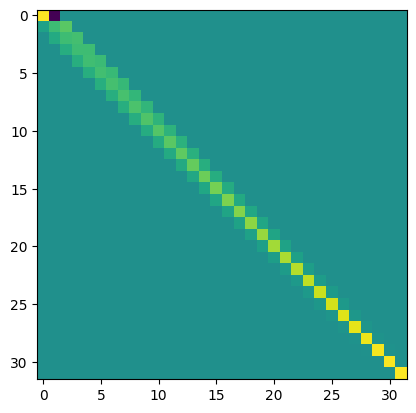

In [10]:
A = create_matrix(delta, b, xi, 0.0001)
plt.imshow(A)
s = spectral_radius(A)
s

b = 1.0
Spectral rad:1.000005691076755
1.99256272249432e-15


0.9995215830335143

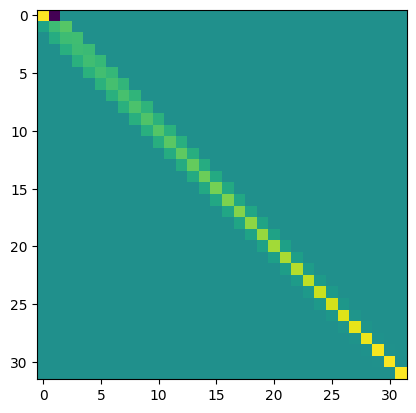

In [22]:
delta_new, dt = update_profile(delta, b, xi, DT)
A2 = create_matrix(delta_new, b, xi, 0.0001)
plt.imshow(A2)
spectral_radius(A2)

In [59]:
#xi, times, bs, volumes, deltas = main_simulation()

## Implicit Method

In [69]:
def trapezoidal_integral(r, u):
    integral = 0.0
    for i in range(1, len(u)):
        area = np.pi * (r[i]**2 - r[i-1]**2)
        average_height = (u[i] + u[i-1]) / 2
        integral += area * average_height
    return integral


def create_matrix(u, d, xi):
    # Creates Matrix A for Implicit Solver A*u^{n+1} = RHS^{n}
    k = G*DT/3/NU
    N = len(xi)
    dxi = xi[1] - xi[0]
    Out = np.zeros((N,N))
    # Inner Points
    for i in range(1, N-1):
        #print(b)
        a = u[i]**3 / d**2
        b = 3*u[i]**2 / d**2
        
        A = a*k*(1/dxi**2 - 1/(2*xi[i]*dxi)) + k*b/4/dxi**2*(u[i-1] - u[i+1])
        B = (-1 - 2*a*k/dxi**2)
        C = a*k*(1/dxi**2 + 1/(2*xi[i]*dxi)) + k*b/4/dxi**2*(u[i+1] - u[i-1])
        
        Out[i,i-1] = A
        Out[i,i] = B
        Out[i,i+1] = C

    # Boundary Points
    Out[N-1,N-1] = 1
    Out[0,0] = 1
    Out[0,1] = -1

    #print(Out)
    return Out    

def update_profile(delta, b, xi):
    delta_new = delta
    err = 1

    RHS = np.zeros(N)
    RHS[1:-2] = -delta[1:-2]

    # Converge on solution
    # Guess delta_new = delta
    delta_new = delta
    err = 1
    while err > 1E-10:
        # solve for delta_new through matrix inversion
        A = create_matrix(delta_new, b, xi)
        delta_new_2 = np.linalg.solve(A, RHS)
        err = np.abs(np.max(delta_new_2 - delta_new))
        delta_new = delta_new_2

    return delta_new

def main_simulation():
    xi = np.linspace(0, 1, N)
    delta = np.sqrt(1 - xi**2)
    b = 1.0
    V0 = trapezoidal_integral(b * xi, delta)

    volumes = []
    bs = []
    times = []
    deltas = []

    for time in np.arange(0, SIMULATION_TIME, DT):
        delta_new = update_profile(delta, b, xi)
        V_new = trapezoidal_integral(b * xi, delta_new)
        if V_new > 0:
            b *= (V0 / V_new)**(1/3)
        delta = delta_new
        volumes.append(V_new)
        bs.append(b)
        times.append(time)
        deltas.append(delta.copy())

    return xi, times, bs, volumes, deltas



In [83]:
DT = 0.1
SIMULATION_TIME = 10000
xi, times, bs, volumes, deltas = main_simulation()

KeyboardInterrupt: 

In [62]:
xi = np.linspace(0, 1, N)
delta = np.sqrt(1 - xi**2)
b = 1.0
V0 = trapezoidal_integral(b * xi, delta)

In [40]:
delta_new = update_profile(delta, b, xi)

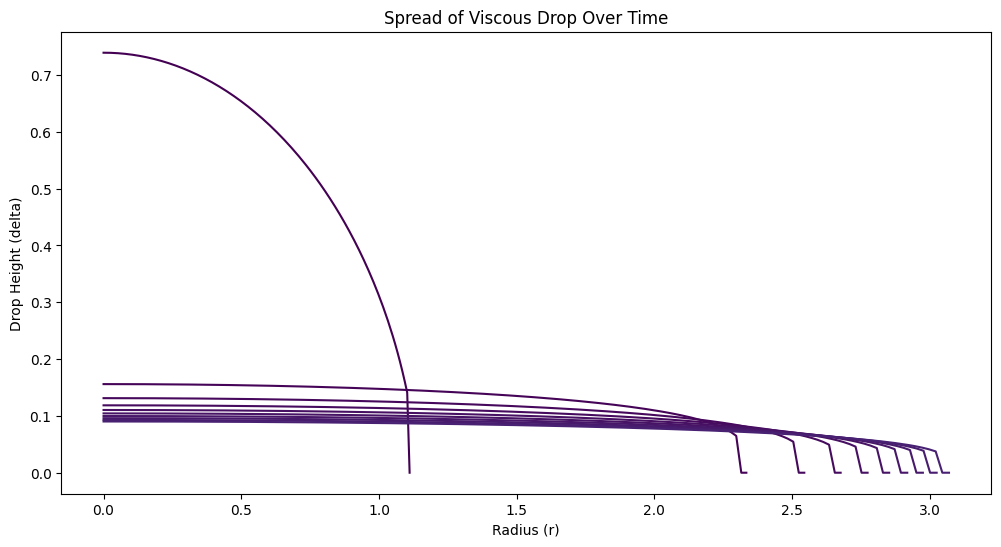

In [84]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize

# Configuración inicial para la coloración
cmap = cm.viridis
norm = Normalize(vmin=0, vmax=SIMULATION_TIME)
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

plt.figure(figsize=(12, 6))

step = int(len(times) / 10) 

for i in range(0, len(deltas), step):
    plt.plot(xi * bs[i], deltas[i], color=cmap(norm(times[i])))

#plt.colorbar(sm, label='Time (s)')
plt.xlabel('Radius (r)')
plt.ylabel('Drop Height (delta)')
plt.title('Spread of Viscous Drop Over Time')
plt.show()



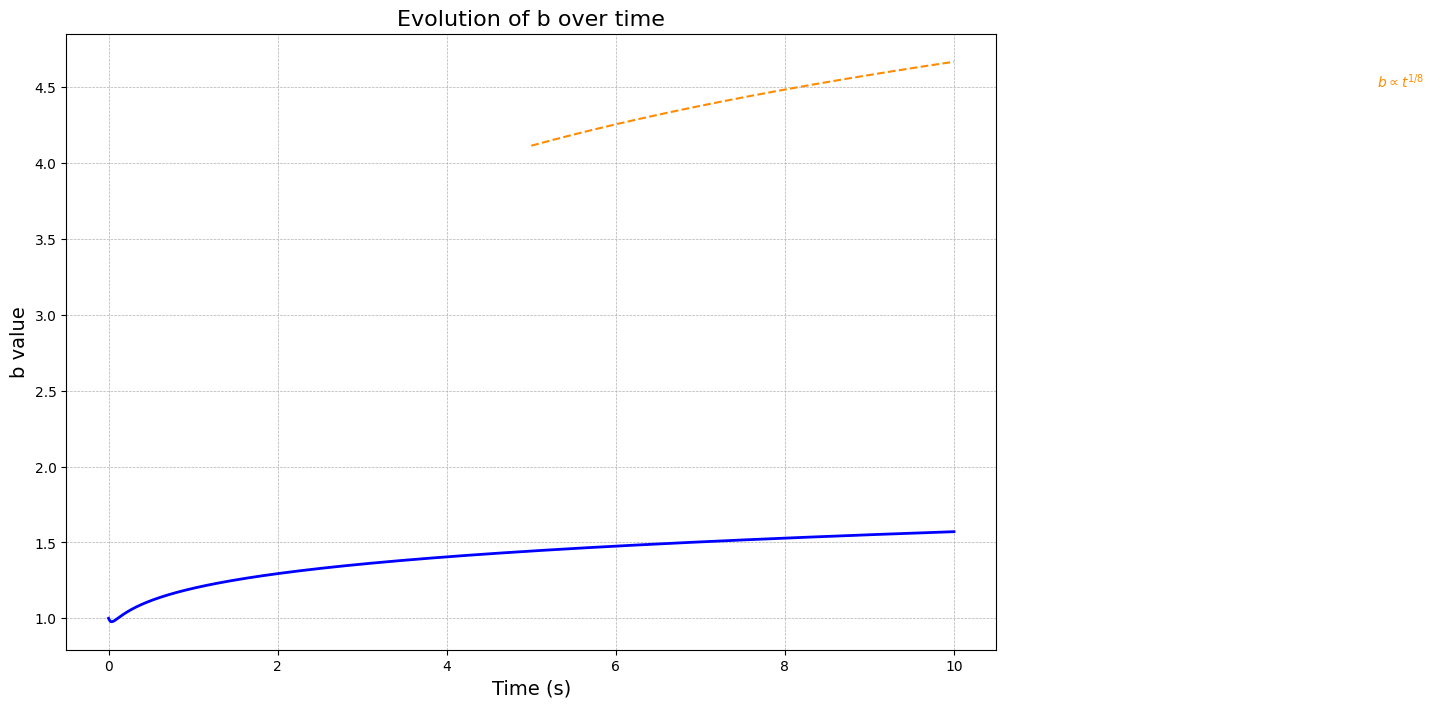

In [8]:
times = np.array(times)  
bs = np.array(bs)

start_index = np.where(times > 5)[0][0]  
plt.figure(figsize=(12, 8))

plt.plot(times[start_index:], 5 * times[start_index:]**(1/8) - 2, label=r'$C \cdot t^{1/8}$', linestyle='--', color='darkorange')
plt.text(15,4.5, r'$b \propto t^{1/8}$',color = 'darkorange' )

plt.plot(times, bs, label='b over time', color='blue', linewidth=2)

plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('b value', fontsize=14)
plt.title('Evolution of b over time', fontsize=16)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
#plt.legend(fontsize=12)

plt.show()



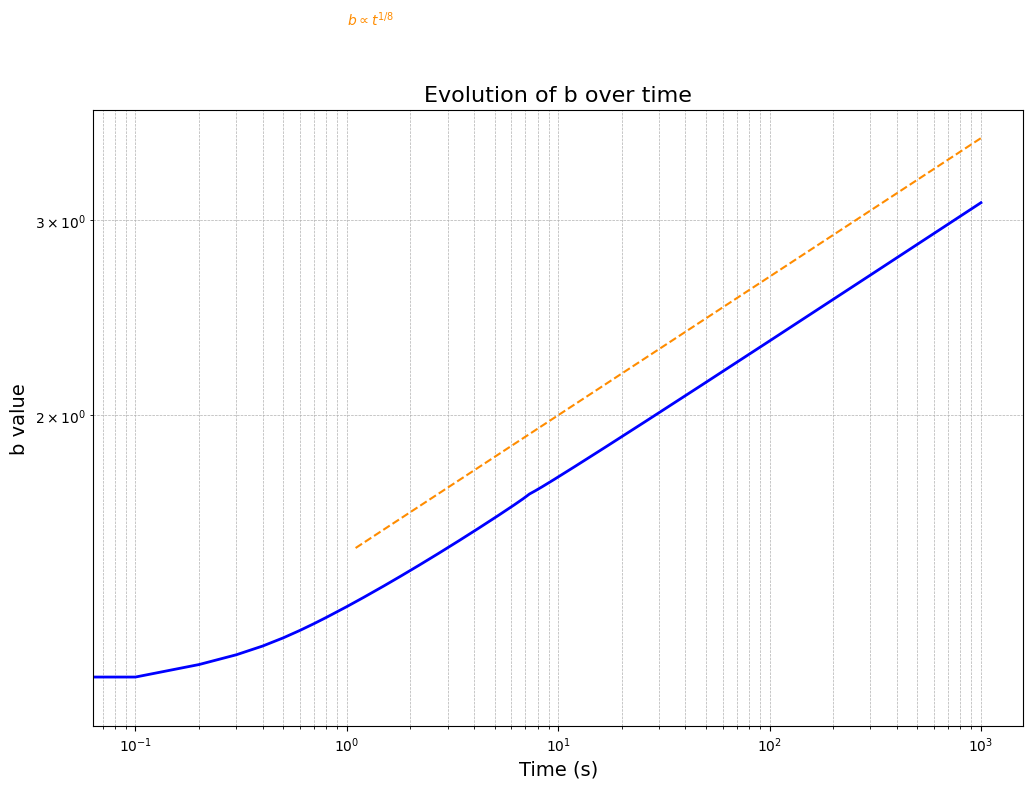

In [87]:
times = np.array(times)  
bs = np.array(bs)

start_index = np.where(times > 1)[0][0]  
plt.figure(figsize=(12, 8))

plt.plot(times[start_index:],  1.5*times[start_index:]**(1/8) , label=r'$C \cdot t^{1/8}$', linestyle='--', color='darkorange')
plt.text(1,4.5, r'$b \propto t^{1/8}$',color = 'darkorange' )

plt.plot(times, bs, label='b over time', color='blue', linewidth=2)

plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('b value', fontsize=14)
plt.title('Evolution of b over time', fontsize=16)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
#plt.legend(fontsize=12)
plt.yscale('log')
plt.xscale('log')
plt.show()

In [91]:
volumes

[1.5251830622029396,
 1.8354900494032906,
 1.9360553075851081,
 1.969712620878789,
 1.9818917616277918,
 1.9897144895592778,
 1.997850911829795,
 2.0062409120181326,
 2.014022324305163,
 2.0208871421972674,
 2.026823201045807,
 2.0319302991967625,
 2.0363353818280387,
 2.040157487832459,
 2.0434974770097134,
 2.0464375277413396,
 2.0490436928028,
 2.051368976614647,
 2.0534560885120925,
 2.0553396762401652,
 2.0570480686954227,
 2.058604616333159,
 2.0600287192742313,
 2.06133661827016,
 2.0625420068428966,
 2.063656508493382,
 2.064690051641053,
 2.0656511665489967,
 2.0665472222968004,
 2.0673846173248336,
 2.0681689337436375,
 2.06890506314843,
 2.0695973098598306,
 2.070249476154411,
 2.0708649330279263,
 2.07144667926105,
 2.07199739096749,
 2.0725194633509747,
 2.0730150460464567,
 2.073486073147057,
 2.073934288803221,
 2.074361269109999,
 2.0747684408625915,
 2.0751570976501905,
 2.075528413668869,
 2.0758834555595578,
 2.0762231925140853,
 2.0765485048368424,
 2.07686019109876

In [88]:
import numpy as np
import matplotlib.pyplot as plt

# Constants for scaling
C = 1  # Adjust as per the problem's requirement for correct scaling
G = 9.81  # Gravitational constant
 
xi = np.linspace(0, 1, N)
delta = np.sqrt(1 - xi**2)
b = 1.0
V0 = trapezoidal_integral(b * xi, delta)

def plot_similarity_solution(xi, times, bs, deltas, V0):
    plt.figure(figsize=(10, 6))
    cmap = cm.viridis  # Choose a colormap
    norm = Normalize(vmin=min(times), vmax=max(times))  # Normalize times for color mapping

    # Create a ScalarMappable for the colorbar
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    # Calculate how many points to skip to reduce the plot to about 100 points
    step = max(1, len(times) // 100)

    # Plot each profile with color mapped to time
    for i in range(0, len(times), step):
        time = times[i]
        if time >= 0:  # Avoid division by zero and initial time
            nu = xi * bs[i] * (3 * np.pi**3 * C**3 / (V0**3 * G * time))**(1/8)
            f = deltas[i] / (3 * V0 * (1 / (16 * np.pi * C * G * time)))**(1/4)
            plt.plot(nu, f, color=cmap(norm(time)))

    #plt.colorbar(sm, label='Time (s)')
    plt.xlabel(r'$\nu$')
    plt.ylabel(r'$f(\nu)$')
    plt.title('Self-similar Solution Over Time')
    plt.xlim([0,4])  
    plt.grid(True)
    plt.show()



C:\Users\skobl\AppData\Local\Temp\ipykernel_12124\3023112765.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  nu = xi * bs[i] * (3 * np.pi**3 * C**3 / (V0**3 * G * time))**(1/8)
C:\Users\skobl\AppData\Local\Temp\ipykernel_12124\3023112765.py:29: RuntimeWarning: invalid value encountered in multiply
  nu = xi * bs[i] * (3 * np.pi**3 * C**3 / (V0**3 * G * time))**(1/8)
C:\Users\skobl\AppData\Local\Temp\ipykernel_12124\3023112765.py:30: RuntimeWarning: divide by zero encountered in scalar divide
  f = deltas[i] / (3 * V0 * (1 / (16 * np.pi * C * G * time)))**(1/4)


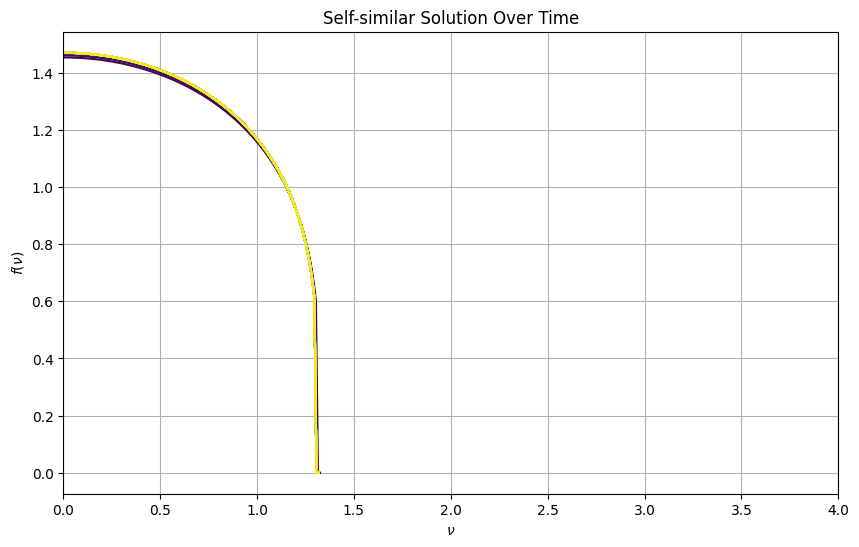

In [89]:
#xi, times, bs, volumes, deltas = main_simulation()
plot_similarity_solution(xi, times, bs, deltas, V0)

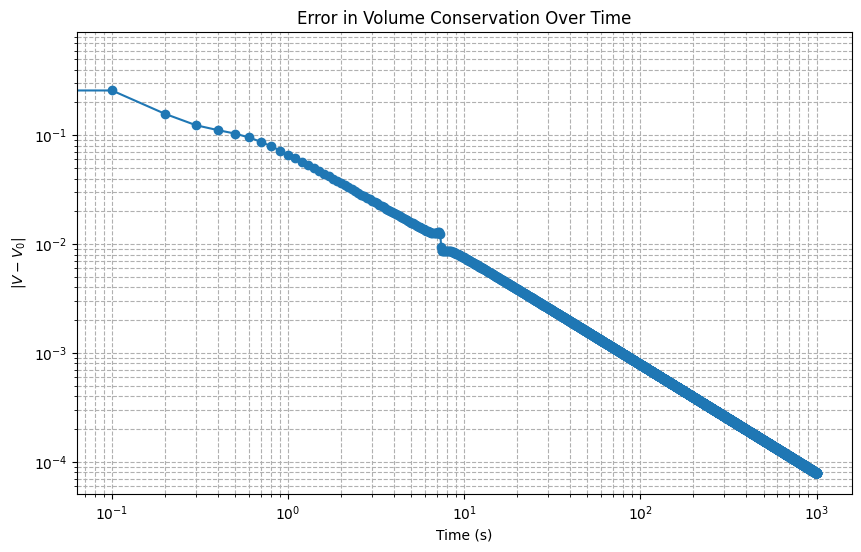

In [90]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate absolute difference from the initial volume
volume_errors = np.abs(np.array(volumes) - V0)

# Plotting the error over time on a logarithmic scale
plt.figure(figsize=(10, 6))
plt.loglog(times, volume_errors, marker='o', linestyle='-')
plt.xlabel('Time (s)')
plt.ylabel(r'$|V-V_0|$')
plt.title('Error in Volume Conservation Over Time')
plt.grid(True, which="both", ls="--")
plt.show()


In [50]:
bs

array([1.00279203, 1.0037242 , 1.00403488, ..., 1.0692559 , 1.06926271,
       1.06926952])